# Around Black-Scholes and Local Volatility

We offer you the following practical task on Black-Scholes and local volatility models.

Total score is **100**, which will be converted to $22\%$ of the course grade. You have $1$ month for this work. **Deadline is 1st of December, 23:59 MSK**.

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol Lab1".  Please rename your file as **"SurnameName_Lab1.ipynb"** before sending.

If you have any questions feel free to ask in Telegram https://t.me/v_antipov or https://t.me/igortao.

**Full name:**

**Faculty:**

## Episode 0: Import all python modules you wish 💅 (0 points)

In [1]:
### YOUR IMPORTS HERE

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from collections.abc import Callable
from tqdm.auto import trange



In [2]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets

---

## Episode 1: Around Black-Scholes model 🧠 (50 points)

**1**. 💅 <span style="color:blue">(10 points)</span>  

A call spread is an option strategy in which a call option is bought, and another less expensive call option is sold. That is, the payoff of the call spread at expiration $T$ can be given as

$$\text{Call-spread}(K_1, K_2) = (S_T - K_1)_{+} - (S_T - K_2)_{+}, \qquad K_1 < K_2.$$

Plot **call-spread** option prices as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters

$$K_1 = 1, \quad K_2 = 1.2, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

In [3]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]

    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

@dataclass
class BSParams:
    volatility: Floats

def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))

    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price

    return np.where(option.is_call, call_price, put_price)

In [4]:
interest_rate = 0
K1 = 1.0
K2 = 1.2
Vols = [0.1, 0.2, 0.3]
Stock = np.linspace(0.5, 1.5, 45)
Expiration = np.linspace(0, 1, 5)

option_1 = CallStockOption(strike_price=np.array(K1), expiration_time=Expiration[:, None])
option_2 = CallStockOption(strike_price=np.array(K2), expiration_time=Expiration[:, None])
Market = MarketState(stock_price=Stock, interest_rate=interest_rate)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')



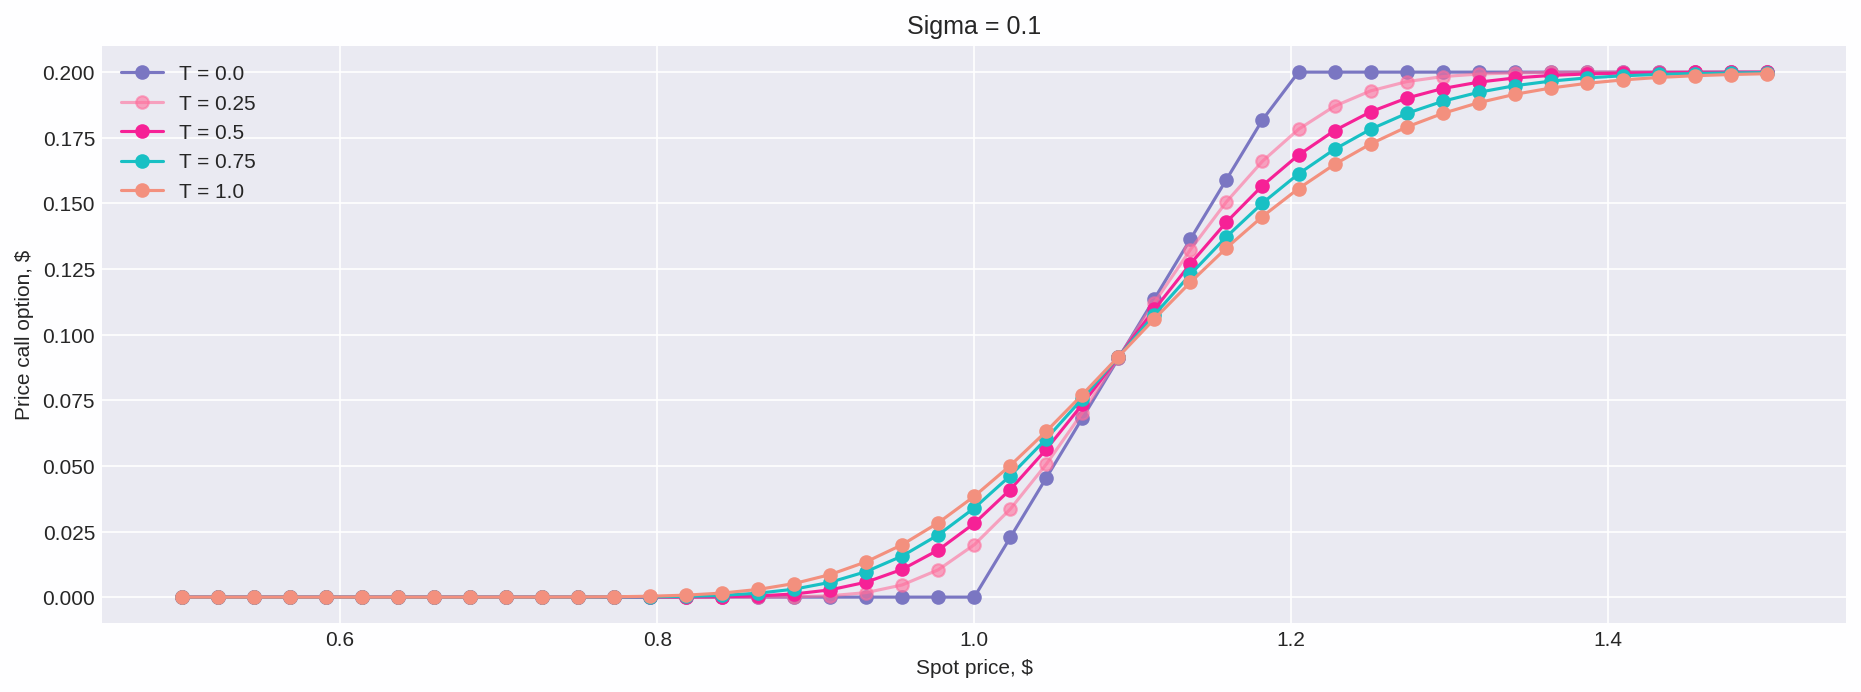

In [5]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)
params = BSParams(volatility=Vols[0])
ax.plot(Stock, price(option_1, Market, params).T - price(option_2, Market, params).T, "o-", label=list(map(lambda x : "T = " + str(x) , Expiration)))
ax.set_title(f"Sigma = {Vols[0]}")
ax.set_xlabel("Spot price, $")
ax.set_ylabel("Price call option, $")
ax.legend()


plt.show()

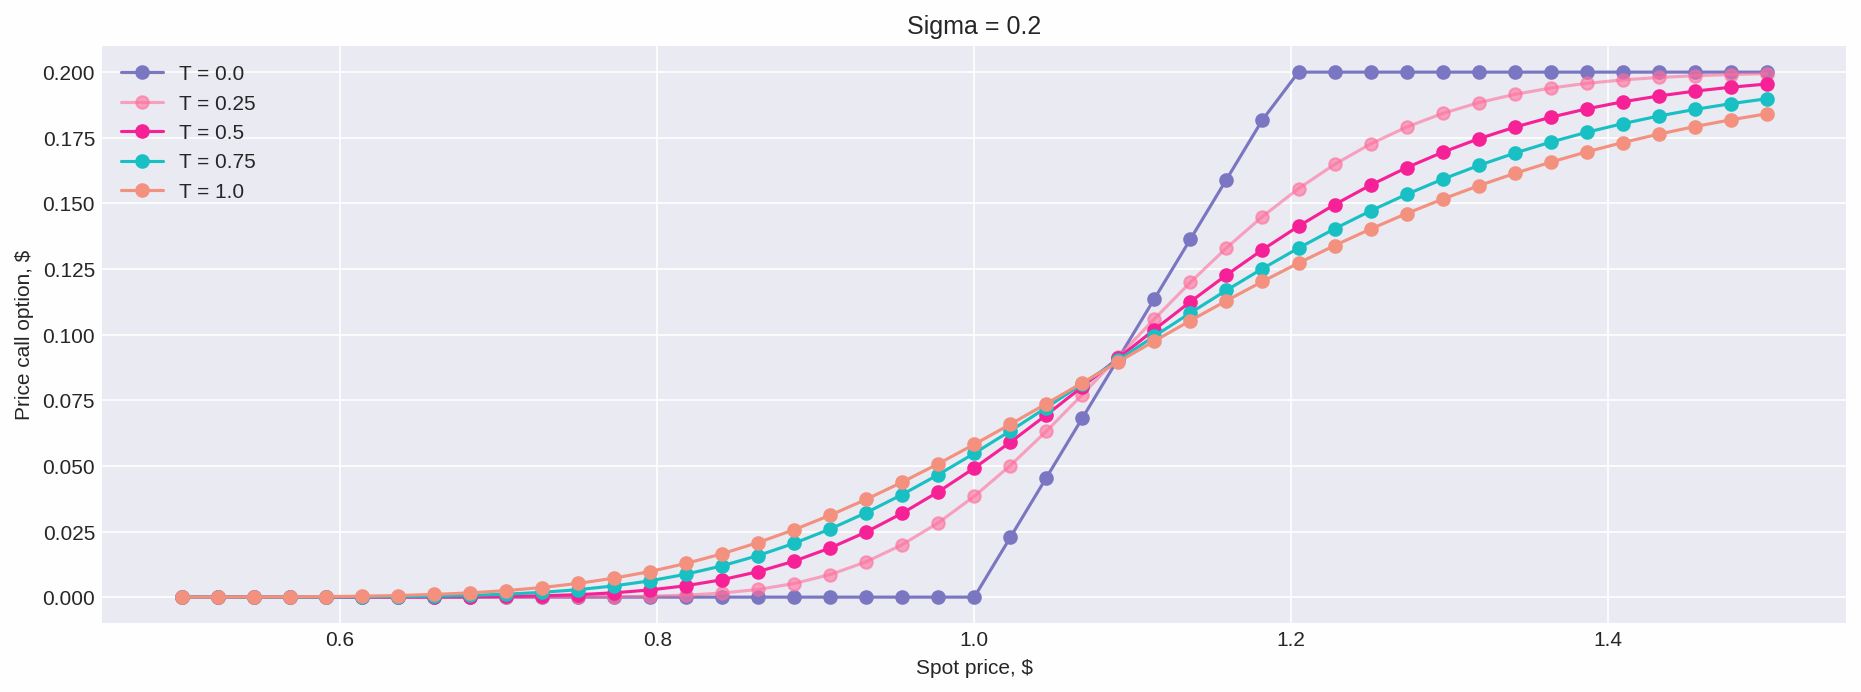

In [6]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)
params = BSParams(volatility=Vols[1])
ax.plot(Stock, price(option_1, Market, params).T - price(option_2, Market, params).T, "o-", label=list(map(lambda x : "T = " + str(x) , Expiration)))
ax.set_title(f"Sigma = {Vols[1]}")
ax.set_xlabel("Spot price, $")
ax.set_ylabel("Price call option, $")
ax.legend()


plt.show()

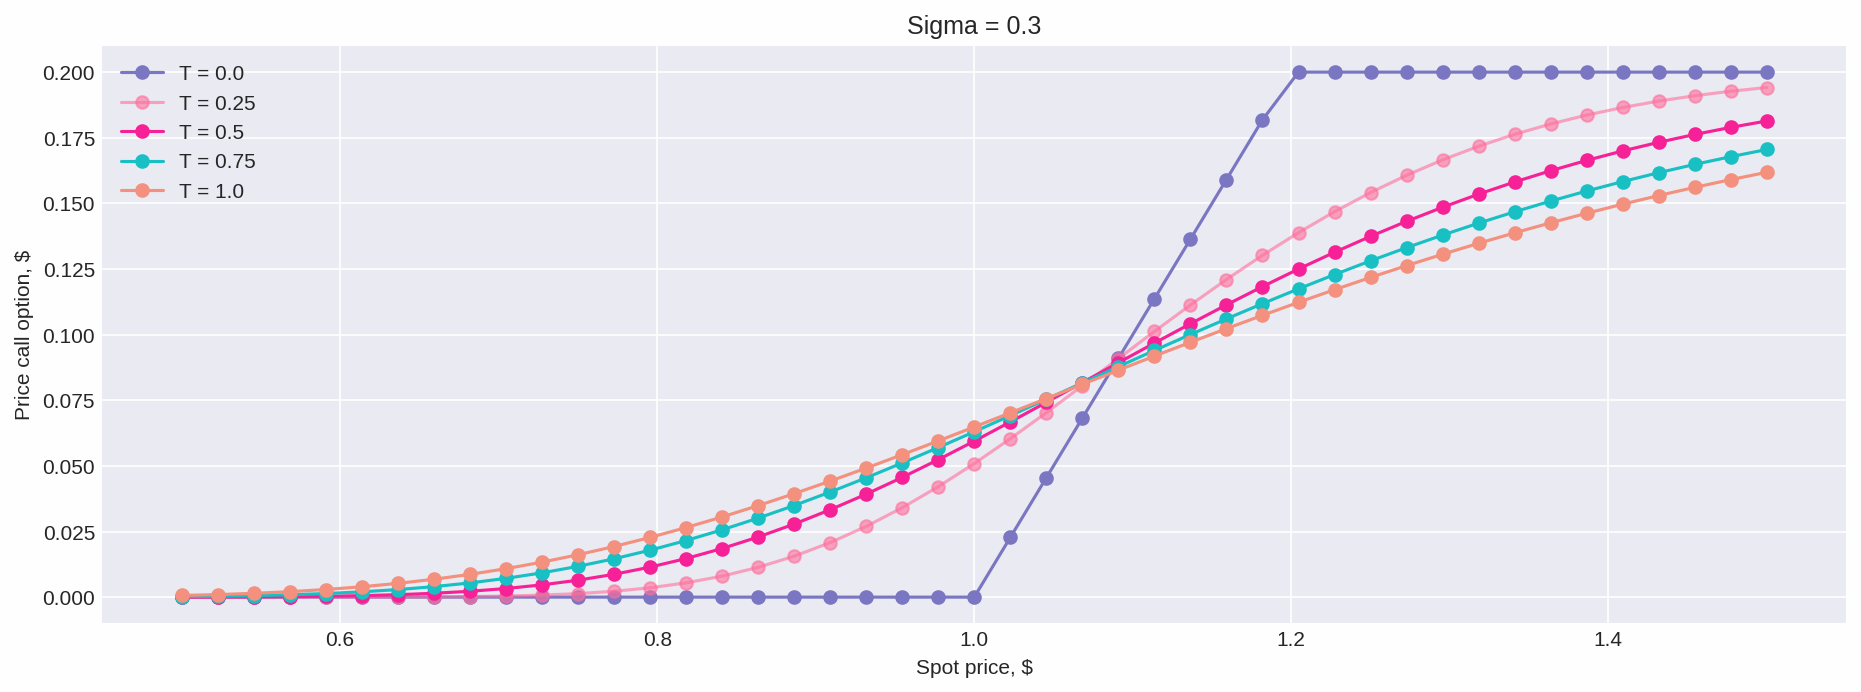

In [7]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)
params = BSParams(volatility=Vols[2])
ax.plot(Stock, price(option_1, Market, params).T - price(option_2, Market, params).T, "o-", label=list(map(lambda x : "T = " + str(x) , Expiration)))
ax.set_title(f"Sigma = {Vols[2]}")
ax.set_xlabel("Spot price, $")
ax.set_ylabel("Price call option, $")
ax.legend()


plt.show()

---

**2**. 💅 <span style="color:blue">(10 points)</span>  What kind of dependence on the parameters of call-spread option price do you observe? How does the price of it depend on the spot price $S$, volatility $\sigma$ and time to expiration $T$? Why? Provide the intuition.

Зависимость от времени. Можно заметить, что чем меньше времени до исполнения опциона тем дешевле Out of the Money опционы. Это может быть связано с тем, что чем меньше времени до страйка, тем меньше вероятность того, что цена сможет подскочить вверх и выйти в положительный payoff.Противоположная ситуация для опционов In the Money. Чем меньше времени остаются времени до страйка, тем выше вероятность, что цена удержиться выше страйка, и будет соответсвенно положительный выйгрыш.

Зависимость от волатильности. Чем выше волатильность, тем дороже опционы Out of the Money. Это можно объяснить как: более высокая волатильность вызывает сильную болтанку, и эта сильная болтанка повышает выроятность вырваться ввысь и заработать. Противоположная зависимость с опционами  In the Money. Чем сильнее болтанка, тем выше вероятность, что улетим в низ и не сможем заработать.

Зависимость от стоимости акции. От возрастания цены акции цена опциона возрастает. Достаточно очевидно. Чем выше стоимость акции на момент, тем выше вероятность, что цена акции на момент эспирации будет выше.

---

**4**. 💅 <span style="color:blue">(10 points)</span> Replicate considered call-spread option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.

*Note: use, for instance, $m = 2^{10} - 1$ and $n$ = 123*.

*Note: Remember that you are replicating your call-spread in Black-Scholes model. So, you may use any formulas available in this model (Black-Scholes option's price formula, greeks, etc.) .*

In [8]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 200,
):

    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))

    return simulate

def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)

def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 200,
    n_paths: int = 1000,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc

    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )

    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params)
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)


n = 123
m = 2**10 - 1
T = 1.0

option_1 = CallStockOption(strike_price=1.0, expiration_time=1.0)
option_2 = CallStockOption(strike_price=1.2, expiration_time=1.0)
Market = MarketState(stock_price=1.0, interest_rate=0.0)
params = BSParams(volatility=0.1)

In [9]:
pl_1 = -calc_hedging_pnl(
    option_1,
    Market,
    params,
    n_paths=n,
    n_steps=m,
    seed=100,
).sum(-1)

pl_2 = -calc_hedging_pnl(
    option_2,
    Market,
    params,
    n_paths=n,
    n_steps=m,
    seed=100,
).sum(-1)

pl = pl_1 - pl_2

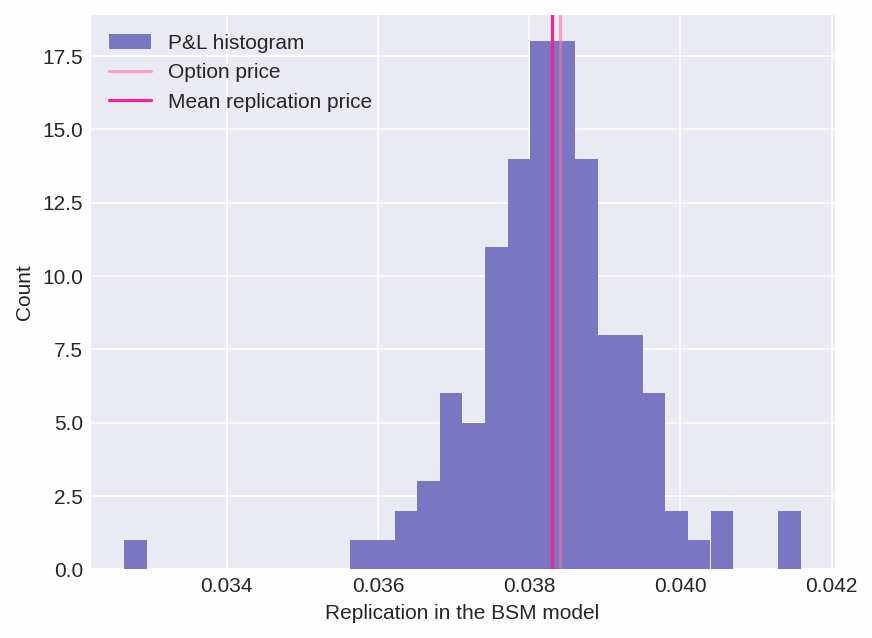

In [10]:
p = price(option_1, Market, params) - price(option_2, Market, params)

_, ax = plt.subplots(dpi=150)
ax.hist(pl, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model")
ax.set_ylabel("Count")
ax.legend()
plt.show()

---

**5**. 🧠 <span style="color:blue">(20 points)</span> Let $C_{call} (S_t, r, \sigma, t) := C(t, S_t)$ be a call option price where $C(t, S)$ satisfies BS equation. Suppose that we sell a call option at $t=0$ at implied volatility $\hat \sigma$, i.e. we get the premium $C_{call}(S_0, r, \hat \sigma, 0)$. Hence the hedging strategy is such that the number of the risky asset held at time $t$ is $$H_t = \dfrac{\partial C}{\partial S}.$$ Moreover, suppose that the true dynamics of asset price is **not** geometric Brownian motion $dS_t = r S_t dt + \sigma S_t dW_t$, but is given by more general Ito process

$$dS_t = \alpha_t S_t dt + \beta_t S_t dW_t. $$  

5.1 <span style="color:blue">(2 points out of 20)</span> Using strategy $H_t$, write SDE for the value $X_t$ of hedging portfolio, assuming that we hold $\dfrac{\partial C}{\partial S}$ units of risky asset and $X_t - \dfrac{\partial C}{\partial S} S_t$ money in riskless one.




\begin{align}
    dX_t
        &= G_t dB_t + H_t dS_t
        \\
        &= G_t dB_t + \dfrac{\partial C}{\partial S} dS_t
        \\
        &= \frac{X_t - \dfrac{\partial C}{\partial S} S_t}{B_t} dB_t + \dfrac{\partial C}{\partial S} dS_t
        \\
        &=  \frac{X_t - \dfrac{\partial C}{\partial S} S_t}{B_t} r B_t dt + \dfrac{\partial C}{\partial S}(\alpha_t S_t dt + \beta_t S_t dW_t)
        \\
        &= (X_t - \dfrac{\partial C}{\partial S} S_t)r dt + \dfrac{\partial C}{\partial S}(\alpha_t S_t dt + \beta_t S_t dW_t)
        \\
        &= (r X_t + (\alpha_t - r) \dfrac{\partial C}{\partial S} S_t)dt + \beta_t \dfrac{\partial C}{\partial S} S_t dW_t \ .
\end{align}


То есть мы получили:

$$
dX_t = \left(r X_t + (\alpha_t - r)\dfrac{\partial C}{\partial S}S_t \right)dt + \beta_t \dfrac{\partial C}{\partial S} S_t dW_t \ .
$$
Использовали самофинансируемость

5.2 <span style="color:blue">(2 points out of 20)</span> Assume that $Y_t = C(t, S_t)$. Applying Ito formula to $Y_t$, write SDE for $Y_t$.  

$$
d Y_t = \left(\dfrac{\partial Y}{\partial t}  + \alpha_t S_t \dfrac{\partial Y}{\partial S} + \dfrac{1}{2} \beta^2_t S^2_t \dfrac{\partial^2 Y}{\partial S^2} \right) dt + \beta_t S_t \frac{\partial Y}{\partial S}dW(t)
$$
$$или$$
$$
d Y_t = \left(\dfrac{\partial C}{\partial t}  + \alpha_t S_t \dfrac{\partial C}{\partial S} + \dfrac{1}{2} \beta^2_t S^2_t \dfrac{\partial^2 C}{\partial S^2} \right) dt + \beta_t S_t \frac{\partial C}{\partial S}dW(t)
$$


5.3 <span style="color:blue">(6 points out of 20)</span> Using answers from 5.1 and 5.2 and BS equation, show that hedging error $Z_t = X_t - Y_t$ satisfies

$$\dfrac{d}{dt} Z_t = r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right).$$

$$
\begin{align}
    dZ_t
        &= dX_t - dY_t
        \\
        &= \left((\alpha_t - r) S_t \dfrac{\partial C}{\partial S} + r X_t\right)dt + \beta_t S_t \dfrac{\partial C}{\partial S} dW_t - \left(\dfrac{\partial C}{\partial t}  + \alpha_t S_t \dfrac{\partial C}{\partial S} + \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 C}{\partial S^2} \right) dt - \beta_t S_t \frac{\partial C}{\partial S}dW_t
        \\
        &= \left((\alpha_t - r) S_t \dfrac{\partial C}{\partial S} + r X_t\right)dt - \left(\dfrac{\partial C}{\partial t}  + \alpha_t S_t \dfrac{\partial C}{\partial S} + \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 C}{\partial S^2} \right) dt
        \\
        &= \left( - r S_t \dfrac{\partial C}{\partial S} - \dfrac{\partial C}{\partial t} + r X_t - \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 Y}{\partial S^2}\right) dt
\end{align} $$


 Используем формулу Фейнмана-Каца(через уравнение Блэка-Шоулза):
 $$ \frac{\partial C}{\partial t} + \frac{1}{2}\hat \sigma^2  S_t^2\frac{\partial^2 C}{\partial S^2} - r C + r S_t \frac{\partial C}{\partial S} = 0
 $$
 $$ \begin{align}     Продолжаем   &= \left(\frac{\hat{\sigma}^2}{2}S_t^2 \frac{\partial^2 C}{\partial S^2} - rC(t, S_t) + r X_t - \dfrac{\beta^2_t S^2_t}{2} \dfrac{\partial^2 C}{\partial S^2}\right) dt
        \\
        &= \left(r(X_t -  Y_t) + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right) \right)dt
        \\
        &= \left(r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right) \right)dt
\end{align}
$$
То есть получили необходимое

5.4 <span style="color:blue">(6 points out of 20)</span> Solve the equation for $Z_t$ above and show that

$$Z_T = \int_{0}^{T} e^{r(T-s)} \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_t^2 \right) dt. $$

Найдём через формулу Ито $Z_t = K(t) e^{rt}$.  Воспользуемся предыдущим результатом:
$$
\frac{d}{dt}Z_t = r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right) = r Z_t + V(t) \ ,
$$
где
$$
V(t)=\dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_t^2 \right)
$$
Далее дифференцируем:
$$
\frac{d}{dt}Z_t = K'(t) e^{rt} + K(t) r e^{rt} = K'(t) e^{rt} + r Z_t \ .
$$
Следовательно:
$$
K' e^{rt} = V(t)
$$
Далее:
$$
 K(t) = \int\limits_0^t  e^{-rs}V(s)ds = \int\limits_0^t  e^{-rs} \dfrac{1}{2} S_s^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_s^2 \right) ds
$$
То есть:
$$Z_T = K(T)e^{rT} =  \int_{0}^{T} e^{r(T-s)} \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_t^2 \right) dt. $$

5.5 <span style="color:blue">(4 points out of 20)</span> Looking at the results above, is it possible to make a **profit with probability one** even though the true price model is substantially different from the assumed model (GBM)? What condition is sufficient for getting this profit?

$\dfrac{\partial^2 C}{\partial S^2} \ge 0$, следовательно, в подынтегральном выражении все члены положительны кроме $ ( \hat \sigma^2 - \beta_t^2 )$. Следовательно, знак этого множителя управляет величинами приращений. Зная смены знака, можно  получать прибыль с вероятностью 1.



---

---

## Episode 2: Local volatility from Monte Carlo perspective 🧠 (50 points)

Here you need to implement the Monte-Carlo pricing in Local Volatility model. For that purpose, you can use the standrad *Euler* discretization scheme:

$$S_{t_{i + 1}} = S_{t_i} + \sigma_{Dup}(t_i, S_{t_i}) \Delta W_{t_i}.$$

However, direct usage of such scheme may lead to negative values of the prices $S_t$. For that reason, you may apply the Euler scheme to $\log(S_{t_i})$ and then finally put $S_{t_i} = e^{X_{t_i}}$. From Ito's formula,

$$X_{t_{i + 1}} = X_{t_i} - \frac{1}{2} \sigma^2_{Dup}(t_i, e^{X_{t_i}}) \Delta t_i+ \sigma_{Dup}(t_i, e^{X_{t_i}}) \Delta W_{t_i}.$$

Notice that for correct implementation, you need a full Dupire volatility surface function. For that reason, you should construct a properly inter-and-extrapolated function $(t, s) \to \sigma_{IV}(t, s)$, obtained from real-market data. Then you may use the well-known formula converting the observed implied volatilites $\sigma_{IV}(t, s)$ to Dupire local volatilies $\sigma_{Dup}(t, s)$:

$$ \sigma_{Dup}(T, K) = \sqrt{\dfrac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w} \frac{\partial w}{\partial y} + \frac{1}{4} ( -\frac{1}{4} - \frac{1}{w} + \frac{y^2}{w^2}) (\frac{\partial w}{\partial y})^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2}}},$$


where
$w(K, T) = \sigma^{2}_{IV}(K, T) \cdot T$ is implied variance and $y = \log(K / F_T)$ is forward log-moneyness.

Use, for instace, spline interpolation in $(w, y)$ coordinates. You may use alo flat extrapolation, i.e. for a pair of arguments $(t, K)$, firstly make the following tranformation

$$ t' = \begin{cases} t_{\min}, & t<t_{\min} \\
   t,        & t \in[t_{\min}, t_{\max}],\\
   t_{\max}, & t > t_{\max},
        \end{cases} \qquad

   s = \begin{cases} s_{\min}, & s<s_{\min}, \\
                     s, & s \in[s_{\min}, s_{\max}], \\
                     s_{\\max}, & s > s_{\max},
        \end{cases} \qquad
$$

where $t_{\min}, t_{\max}, s_{\min}, s_{\max}$ - minimum and maximum values of time to expiration and strikes variables from the market data and
$$\sigma^{new}_{Dup}(t,s) = \sigma_{Dup}(t', s').$$
   

In [11]:
s = 1.0    # spot price S_0
r = 0.0    # zero interest rate

In [14]:
df = pd.read_csv('data.txt', sep = ',')       # Подключаем данные и очищаем
df

,# expiration,strike,call_price
0,0.1,0.65,0.35002
1,0.1,0.70,0.30009
2,0.1,0.75,0.25031
3,0.1,0.80,0.20100
4,0.1,0.85,0.15296
...,...,...,...
100,0.4,1.15,0.02523
101,0.4,1.20,0.01685
102,0.4,1.25,0.01128
103,0.4,1.30,0.00762


In [15]:
df.columns = df.columns.str.replace(" ", "", regex=True)      # Очищаем данные
df.columns = df.columns.str.replace("#", "", regex=True)

In [16]:
df.columns

Index(['expiration', 'strike', 'call_price'], dtype='object')

**1**. 🧠 <span style="color:blue">(10 points)</span>

Extract the data from `data.txt`: strikes, times to expiration and call option prices. Compute the corresponding implied volatilties $\sigma_{IV}(T_i, K_i)$, inter-and-extrapolate them to obtain the whole surface. Plot the calculated implied volatility curves for each time to marutiry $T_i$ and the whole implied volatility surface.

In [12]:
!pip install py_vollib                         # Подключаем библиотеку для использования функции нахождения Implied Volatility
!pip install py_vollib_vectorized
import pandas as pd
import py_vollib as iv
import py_vollib.black.implied_volatility as iv
import py_vollib_vectorized

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.9 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=5a7d8f507b1bc11021e56c9c252ccfc96e2f1319a44b1853bc1c01f1a865c060
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha256=ffe10caa9c323ed2974f044ab1d5c26b181f109888d82d0bf5668654ad093fd1
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py_vollib py_lets_be_rational


/usr/local/lib/python3.10/dist-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [17]:
ivs = iv.implied_volatility(                                # Библиотечная функция подсчета Implied Volatility. Находим через нее волатильности торгуемых опционов кол
    df["call_price"],
    np.exp(r * df["expiration"]) * s,
    df["strike"],
    r,
    df["expiration"],
    "c",
    )

Text(0.5, 0, 'IV vol')

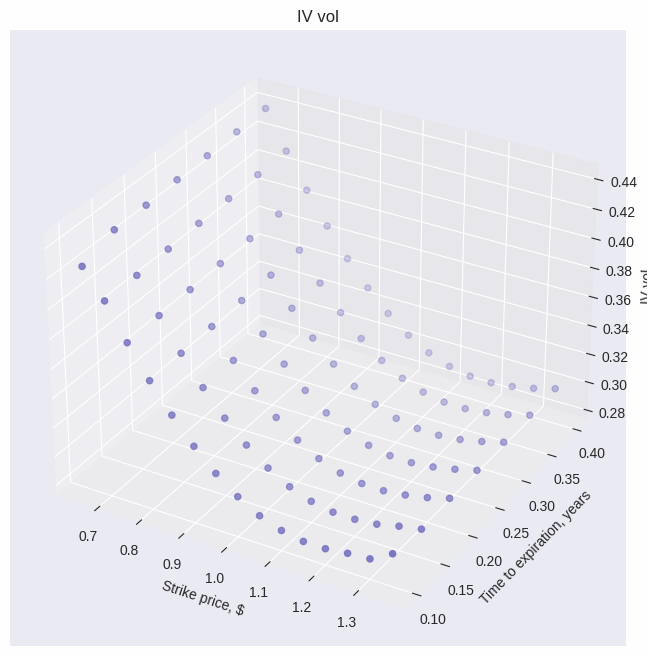

In [18]:
x = df["strike"]                                            # Волатильности для торгуемых опционов кол
y = df["expiration"]
z = ivs

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x, y, z)
ax1.set_title('IV vol')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('IV vol')

In [19]:
from scipy.interpolate import interp1d, SmoothBivariateSpline                   # Подключаем гладкие сплайны
VolInterpolation_2d = SmoothBivariateSpline(df["strike"], df["expiration"], ivs)

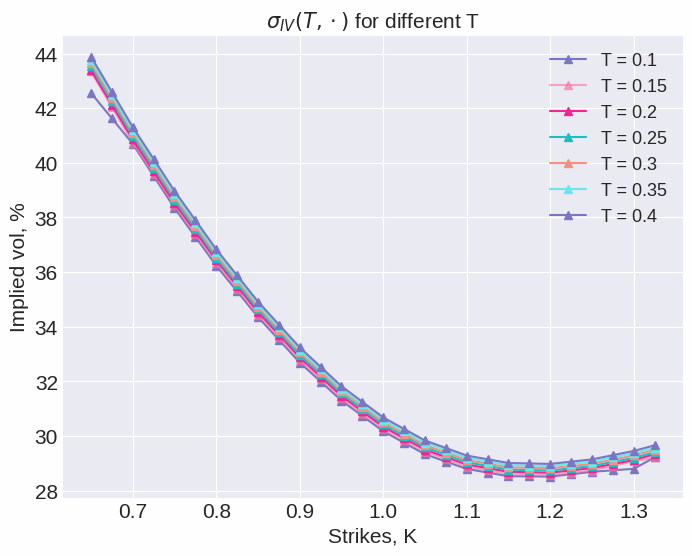

In [20]:
unique_ex = np.unique(np.array(df["expiration"]))          # Одномерные интерполяции Implied Volatility с заданными временами до эсперации
unique_st = np.unique(np.array(df["strike"]))
df['ivs'] = ivs

x = np.arange(0.65, 1.35, 0.025)

plt.figure(figsize=(8, 6))

for el in unique_ex:
  f = interp1d(unique_st, df[df['expiration'] == el]['ivs'])
  y = f(x)
  label="T = {}".format(float(el))
  plt.plot(x, 100 * np.array(y),  label=label, marker = "^")

plt.title("$\sigma_{IV}(T, \cdot)$ for different T", fontsize=15)
plt.ylabel("Implied vol, %", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(prop={'size': 13})
plt.grid(True)

In [21]:
print(min(df["strike"]), max(df["strike"]), min(df["expiration"]), max(df["expiration"]))

0.65 1.35 0.1 0.4


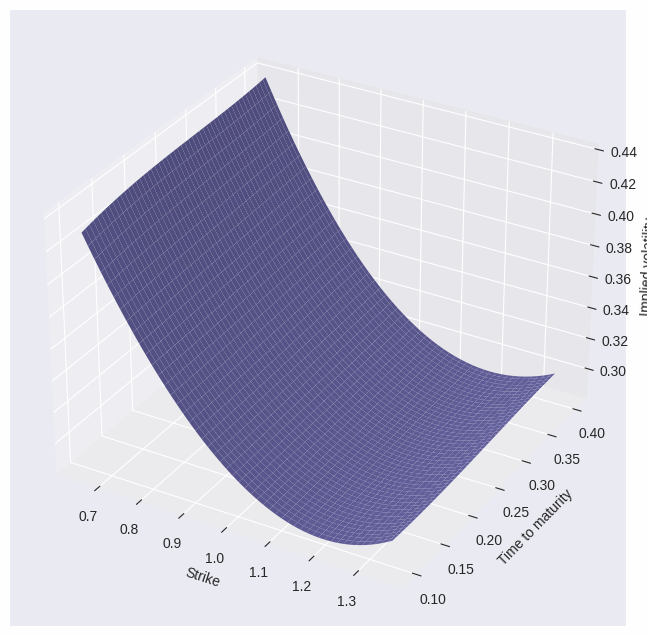

In [22]:
fig = plt.figure(figsize=(15, 8))                       # Вся поверхность Implied Volatility полученная гладкими интерполяционными сплайнами
ax = fig.add_subplot(111, projection='3d')


x = np.linspace(0.65, 1.35, 200)
y = np.linspace(0.1, 0.4, 200)
x, y = np.meshgrid(x, y)
z = VolInterpolation_2d(x, y, grid=False)

ax.set_xlabel('Strike')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Implied volatility')
ax.plot_surface(x, y, z)
plt.show()

**2**. 🧠 <span style="color:blue">(20 points)</span>

Write a function which evaluates a Dupire local volatility at given point, i.e. a function $(t, s) \to \sigma_{Dup}(t, s)$. Please note that it should return an "adequate" value for any input point $(t, s)$ from the considered ranges of strieks and times to expiration. Plot the obtained local volatility surface for a given grid of strikes and times to expiration.

In [23]:
W = df['ivs']**2 * df['expiration']                                # Делаем преобразование к новой системе координат и делаем гладкие сплайны
Y = np.log(df['strike'] / s * np.exp(r * df['expiration']))

W_Interpolation_2d = SmoothBivariateSpline(df["expiration"], Y, W)
dW_dt = W_Interpolation_2d.partial_derivative(dx=1, dy=0)          # Функции частных производных через сплайны
#Сплайн W_y
dW_dy = W_Interpolation_2d.partial_derivative(dx=0, dy=1)
#Сплайн W_yy
d2W_d2y = W_Interpolation_2d.partial_derivative(dx=0, dy=2)

In [24]:
T_min = df['expiration'].min()                        # Находим допустимые края
T_max = df['expiration'].max()
Strikes_min = df['strike'].min()
Strikes_max = df['strike'].max()

In [25]:
def local_volatility(T: np.array, Strikes: np.array):  # Формула Дюпира, используя интерполяцию сплайнами

  T[T < T_min] = T_min
  T[T > T_max] = T_max
  Strikes[Strikes < Strikes_min] = Strikes_min
  Strikes[Strikes > Strikes_max] = Strikes_max

  y = np.log(Strikes/s * np.exp(r * T))

  w =  W_Interpolation_2d(T, y, grid=False)
  w_t = dW_dt(T, y, grid=False)
  w_y = dW_dy(T, y, grid=False)
  w_yy = d2W_d2y(T, y, grid=False)
# Формула Дюпира:
  denominator = 1 - (y * w_y)/w + (1/4) * ( - (1/4) - (1/w) + ((y ** 2)/(w ** 2))) * ((w_y) ** 2) + (w_yy/2)

  return np.sqrt(w_t/denominator)

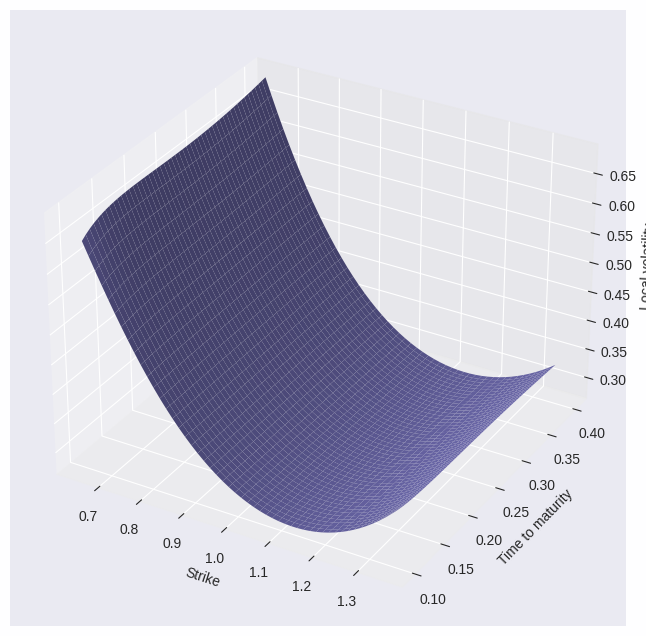

In [26]:
x = np.linspace(Strikes_min, Strikes_max, 50)         # Построим поверхность локальной волательности
y = np.linspace(T_min, T_max, 50)
x, y = np.meshgrid(x, y)
loc_vol = local_volatility(y, x)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Strike')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Local volatility')
ax.plot_surface(x, y, loc_vol)
plt.show()

**3**. 🧠 <span style="color:blue">(20 points)</span>

Implement a Monte-Carlo simulation calculator and price an option with time to expiration $T = 0.25$ for the range of strikes $K = \{ 0.6, 0.7, 0.8, \dots, 1.4\}$. Your calculator should return a range of prices $\{ V(T, K_i)\}$ and implied volatilites $\sigma_{IV}(T, K_i)$ (for each strike $K_i$), with an absolute error not greater than $1\%$ in implied vols for every (almost every) strike $K_i$. Plot on one graph the prices obtained using Monte Carlo and the prices from the file. Also, plot on other graph the implied vols obtained using Monte Carlo and the implied vols obtained in question (1).

In [27]:
def paths(n_paths: int, n_steps: int, T_: float, spot: float, seed: int = 42):          # Функция строит траектории метода Монте-Карло через логарифмическую дискретизацию Эйлера
  dt = T_/n_steps
  random = np.random.default_rng(seed)

  paths = np.empty(shape = (n_paths, n_steps))
  paths[:, 0] = np.full((n_paths), np.log(spot))

  for i in range(1, n_steps):
    loc_vol = local_volatility(np.full((n_paths), (i - 1) * dt), np.exp(paths[:, i - 1]))
    norm = random.normal(size=(n_paths))
 #   print(np.shape(loc_vol))
 #   print(np.shape(norm))
 #   print(np.shape(paths[:, i]))

    paths[:, i] = paths[:, i - 1] - 0.5 * dt * (loc_vol.T)**2 + (loc_vol.T) * np.sqrt(dt) * norm

  return np.exp(paths)

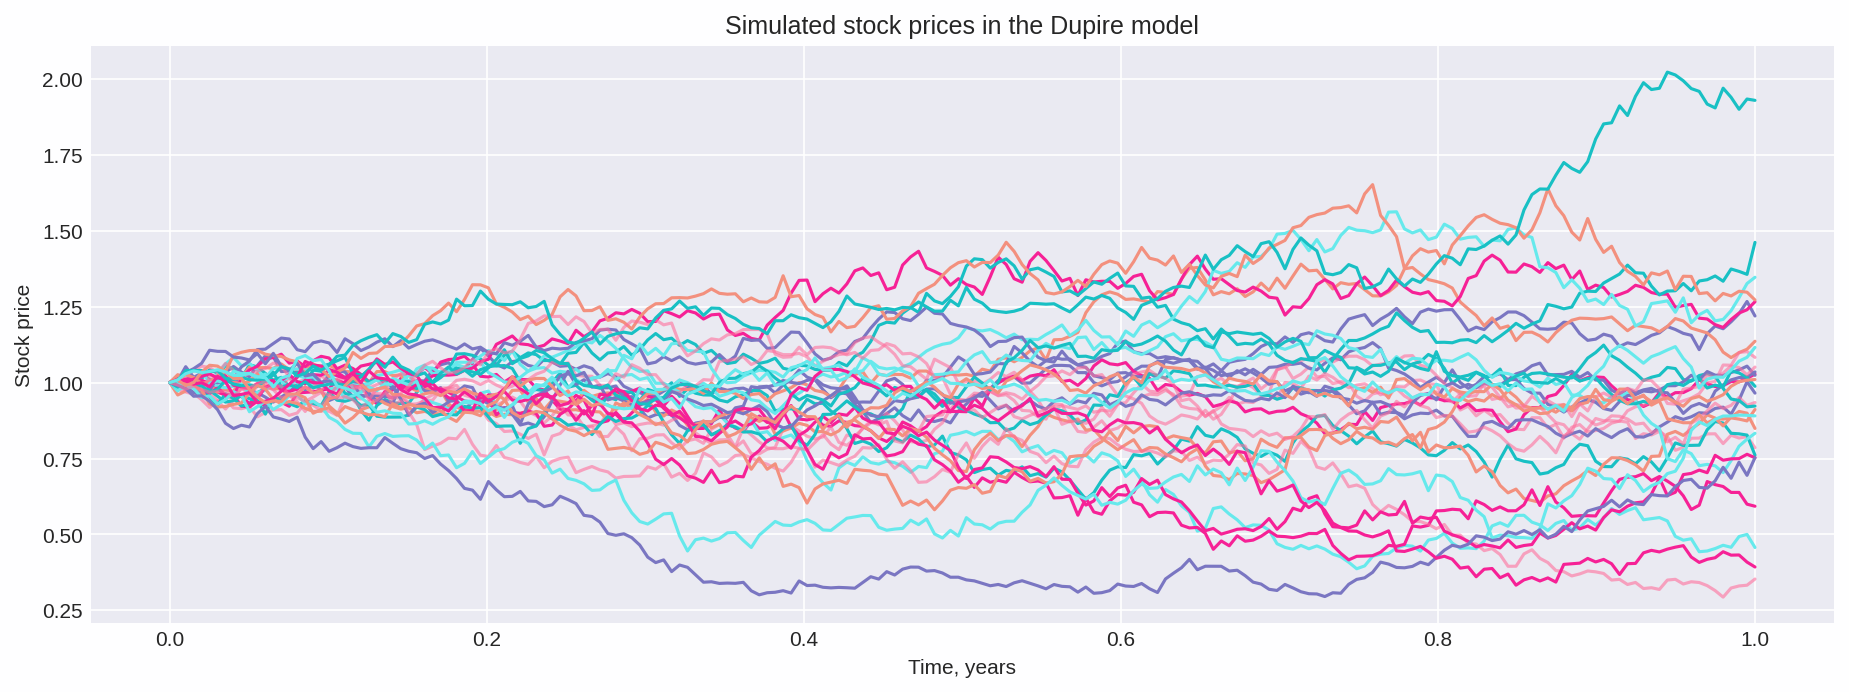

In [28]:
steps = 200                                 # Пример построения  траекторий
p = 30
T = 1

paths_n = paths(p, steps, T, s)

t = np.linspace(0, T, steps)

_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths_n.T)
ax.set_xlabel("Time, years")
ax.set_ylabel("Stock price")
ax.set_title("Simulated stock prices in the Dupire model")
plt.show()

In [29]:
def monte_carlo_price(n_paths: int, n_steps: int, Strikes: np.array, T: float, spot: float):           # Функция нахождения цен опциона кол методом Монте-Карло
  paths_ = paths(n_paths, n_steps, T, spot)

  Strikes = np.reshape(Strikes, (1, Strikes.size))

  Stock = np.reshape(paths_[:, -1], (n_paths, 1))

  return  np.exp(-T * r) * np.mean(np.maximum(0, Stock - Strikes), axis=0)

In [31]:
Strikes = np.arange(0.6, 1.5, 0.1)                                  # Находим цены опционов кол методом Монте-Карло
Expirations = np.full((9), 0.25)
Call_Prices = monte_carlo_price(50000, 200, Strikes, 0.25, s)

In [32]:
Call_Prices

array([0.40085834, 0.30290463, 0.20868823, 0.1247371 , 0.06090592,
       0.02362831, 0.00771858, 0.00236363, 0.00072793])

In [33]:
Call_vols_monte = iv.implied_volatility(                      # Находим волатильности из метода Монте-Карло
    Call_Prices,
    np.exp(r * Expirations) * s,
    Strikes,
    r,
    Expirations,
    "c",
    )

In [34]:
Call_vols_monte = np.array(Call_vols_monte)
Call_vols_monte

array([[0.46321781],
       [0.41194382],
       [0.36468424],
       [0.32998035],
       [0.30563412],
       [0.29189516],
       [0.28817842],
       [0.29142633],
       [0.2980274 ]])

In [35]:
i = 0                                                                  # Выделяем нужные настоящие цены и волатильности со страйками 0.7, 0,8, ..., 1.3
True_Prices = []
True_Vols = []
for p in np.array(df[df['expiration'] == 0.25]['call_price']):
  if i % 2 == 1:

    True_Prices.insert(0, p)
  i = i + 1

i = 0
for p in np.array(df[df['expiration'] == 0.25]['ivs']):
  if i % 2 == 1:

    True_Vols.insert(0, p)
  i = i + 1

True_Prices = np.array(True_Prices)
True_Vols = np.array(True_Vols)


True_Prices = np.flip(True_Prices)
True_Vols = np.flip(True_Vols)
print(True_Prices)
print(True_Vols)

[0.30283 0.20874 0.12469 0.06063 0.02338 0.00764 0.00239]
[0.4099154  0.36529958 0.32967403 0.30424685 0.29042066 0.2873738
 0.29201241]


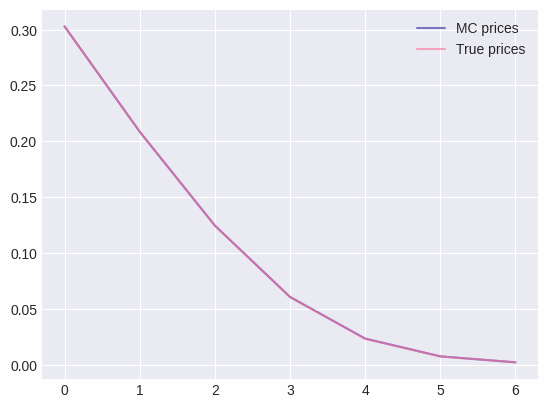

In [36]:
plt.plot(Call_Prices[1:-1], label="MC prices")   # Графики настоящих цен и цен полученных методом Монте-Карло. Cравнение для опционов со страйками 0.7 - 1.3.
plt.plot(True_Prices, label="True prices")
plt.legend()
plt.show()

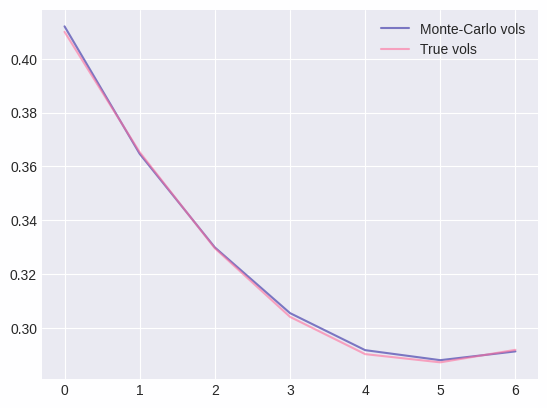

In [37]:
plt.plot(Call_vols_monte[1:-1], label="Monte-Carlo vols")               # Графики сравнения волатильностей настоящих и полученных методов Монте-Карло
plt.plot(True_Vols, label="True vols")
plt.legend()
plt.show()

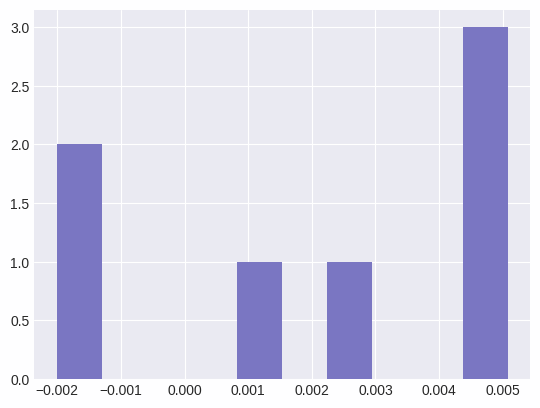

In [38]:
plt.hist((np.reshape(Call_vols_monte[1:-1], (7)) - True_Vols) / True_Vols);    # Ошибки меньше 1% для волатильностей